In [1]:
#kaggle notebook
!pip install torchsummary
!pip install --upgrade torch torchvision torchaudio
!pip install py7zr
!pip install pytorch-model-summary

     |████████████████████████████████| 750.6 MB 8.9 kB/s             7.0 MB/s eta 0:00:25███▋                | 366.6 MB 17.1 MB/s eta 0:00:23 |████████████████▋               | 389.8 MB 36.8 MB/s eta 0:00:10
     |████████████████████████████████| 21.0 MB 41.9 MB/s            
     |████████████████████████████████| 2.9 MB 46.8 MB/s            
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.9.1
    Uninstalling torchaudio-0.9.1:
      Successfully uninstalled torchaudio-0.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependen

In [4]:
#imports
from pathlib import Path
import os
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import sys

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import IPython.display as ipd
from matplotlib.pyplot import figure


from pytorch_model_summary import summary as summ

from tqdm import tqdm

import librosa
import random
import shutil

import warnings

In [5]:
print(torch.__version__)

1.11.0+cu102


In [7]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
!python -m py7zr x ../input/tensorflow-speech-recognition-challenge/train.7z #kaggle notebook

In [9]:
!python -m py7zr x ../input/tensorflow-speech-recognition-challenge/test.7z #kaggle notebook

In [10]:
all = ['one','go', 'two', 'seven', 'bird', 'eight', 'right', 'off', 'yes',
       'stop', 'left', 'nine', 'cat', 'dog','three','on', 'zero', 'five', 'sheila','happy', 'wow', 'six' ,'house', 'marvin','no','four', 'tree' ,'down','bed','up']
classes =[ "yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
no_classes = list(set(all) -  set(classes))
special_classes = ["silence", "unknown"] 

In [11]:
#https://pytorch.org/audio/stable/_modules/torchaudio/datasets/speechcommands.html
def load_speechcommands_item( path: str,filepath: str):
    label, filename = os.path.split(filepath)
    waveform, sample_rate = torchaudio.load(path +'/'+ filepath)
    return label, waveform, sample_rate
    
def _load_folder_list(root):
    return  list(str(p)[len(root)- 1:] for p in Path(root).glob("*/*.wav"))


class _SpeechSubset(Dataset):
    def __init__(self, root, subset, transformation = None):
        self.root = root
        self.subset = subset
        self.transformation = transformation
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        filepath = self.subset[idx]
        label, waveform, sample_rate = load_speechcommands_item(self.root, filepath)
        if self.transformation is not None:
            label, waveform, sample_rate = self.transformation(label, waveform, sample_rate)
        return waveform, sample_rate, label,
    

        
    

class SpeechDataset():
    def __init__(self, root, train_size = None, exclude = None, transformation = None, ):
        self.root = root
        self.train_size = train_size
        self.transformation = transformation
        self.dataset = _load_folder_list(self.root)
        
        if exclude is not None:
            self.dataset = [x for x in self.dataset if exclude(x) == False]
            
        if self.train_size is not None:
            self.train_subset, self.val_subset = train_test_split(self.dataset, train_size=self.train_size)
     
    def __getSubset(self, name):
        if name == "train":
            return _SpeechSubset(self.root, self.train_subset, transformation = self.transformation)
        elif name == "val":
            return _SpeechSubset(self.root, self.val_subset, transformation = self.transformation)
        elif name == "train+val":
            return _SpeechSubset(self.root,  self.dataset, transformation = self.transformation)
        else:
            return None
            
    def getTrainSubset(self,):
        return self.__getSubset("train")
    
    def getValidationSubset(self):
        return self.__getSubset("val")
    
    def getTrainValidationSubset(self):
        return self.__getSubset("train+val")
    
    def getFilenames(self):
        return self.dataset

In [12]:
dataset_noise = SpeechDataset("./train/audio",None, exclude = lambda x: x.startswith('_background_noise_') == False)

whole_set_noise = dataset_noise.getTrainValidationSubset()

In [13]:
dataset_noise.getFilenames()

['_background_noise_/doing_the_dishes.wav',
 '_background_noise_/white_noise.wav',
 '_background_noise_/pink_noise.wav',
 '_background_noise_/dude_miaowing.wav',
 '_background_noise_/running_tap.wav',
 '_background_noise_/exercise_bike.wav']

(torch.Size([1, 1522930]), 0.87557983, 95.183125)

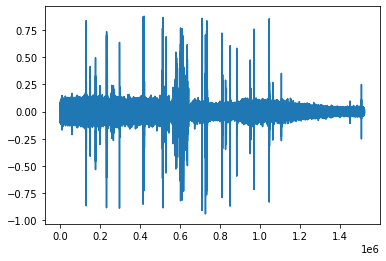

In [14]:
waveform, sample_rate, label,= whole_set_noise[0]

plt.plot(waveform.t().numpy());
waveform.shape, waveform.t().numpy().max(), len(waveform[0]) / 16000

In [15]:
shutil.rmtree('./train/audio/silence', ignore_errors=True)
Path("./train/audio/silence").mkdir(parents=True, exist_ok=True)

low_sum_by_second = 0.5

max_ratio_level = 1
multiplication = 5


for z,(w,s,l) in enumerate(whole_set_noise):
    min_val = len(w[0]) / (s * float(w[0].abs().sum())) * low_sum_by_second
    step = (max_ratio_level - min_val) / multiplication
    print()
    for i in range(multiplication +1):
        ratio = min_val + step * i
        wave = w * ratio
        wave_split = wave.split(16000, dim = 1)
        for j,w1 in enumerate(wave_split):
            Path("./train/audio/silence").mkdir(parents=True, exist_ok=True)
            torchaudio.save('./train/audio/silence/'+str(z) + "_" +str(i) + "_" + str(j)+'.wav', w1, 16000)

In [16]:
dataset_silence = SpeechDataset("./train/audio",None, exclude = lambda x: x.startswith('silence') == False)


whole_set_silence = dataset_silence.getTrainValidationSubset()


In [ ]:
len(whole_set_silence)

In [17]:
dataset = SpeechDataset("./train/audio",0.7, exclude = lambda x: x.startswith('_background_noise_'))

train_set = dataset.getTrainSubset()
val_set = dataset.getValidationSubset()
whole_set = dataset.getTrainValidationSubset()


In [ ]:

print(len(train_set), len(val_set), len(whole_set))

waveform, sample_rate, label,= train_set[0]

plt.plot(waveform.t().numpy());
waveform.shape

In [18]:
labels =['eight',
  'left',
  'down',
  'tree',
  'four',
  'on',
  'dog',
  'happy',
  'wow',
  'one',
  'five',
  'silence',
  'bed',
  'stop',
  'yes',
  'marvin',
  'cat',
  'three',
  'sheila',
  'house',
  'seven',
  'off',
  'two',
  'six',
  'up',
  'go',
  'nine',
  'no',
  'bird',
  'right',
  'zero']

In [19]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(14) --> yes


In [20]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label  in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

In [ ]:

unique, counts = np.unique([x[2] for x in whole_set], return_counts=True)
result = np.column_stack((unique, counts))
result.sort(axis = 1)
result

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        
        return x


model = M5(n_input=1, n_output=len(labels)).cuda()

In [ ]:
from torch.autograd import Variable 
class LSTM1(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size = 2, num_layers = 8):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(496, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda() #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda() #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0,c_0)) #lstm with input, hidden, and internal state
        output = output.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(output)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
    


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = 0.5)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        
        # Forward propagate LSTM
        out, (h,c) = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = h[-1, :, :]
        out = self.fc(out)
        out = F.dropout(out, 0.3)
        return out

In [21]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=80, stride=4)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=16, stride=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(980, hidden_size, num_layers, batch_first=True, dropout = 0.3)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = F.dropout(x, 0.2)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        #x= self.pool2(x)
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        
        # Forward propagate LSTM
        out, (h,c) = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        out = self.fc1(out)
        out = F.dropout(out, 0.3)
        out = self.fc(out)
        return out

In [90]:
model4 = RNN2(16000, 512, 4, len(labels)).cuda()

In [ ]:
print(summ(model4, torch.zeros((64,1,16000)).cuda(), show_input=False))

In [ ]:
print(summ(model4, torch.zeros((64,1,16000)).cuda(), show_input=True))

In [24]:
class UnkownPerformanceMetric():
    def __init__(self, classes):
        self.classes_indexes = torch.tensor([label_to_index(x) for x in classes])
        self.correct = 0
        self.count = 0
    
    def insert(self, input, target):
        indices_input = torch.cat([(input == i).nonzero() for i in self.classes_indexes])
        input[indices_input] = -1
        indices_target = torch.cat([(target == i).nonzero() for i in self.classes_indexes])
        target[indices_target] = -1
        
        values = (input==target)
        self.correct += values.sum().item()
        self.count += len(values)
        
    def print(self, reset = True):
        agg = self.correct / self.count
        print("UnkownPerformanceMetric: ", agg)
        if reset:
            self.reset()
        
    def reset(self):
        self.correct = 0
        self.count = 0
        
metrics1 = UnkownPerformanceMetric(no_classes)

In [ ]:
class NotUnkownPerformanceMetric():
    def __init__(self, unkownIndex):
        self.unkownIndex = unkownIndex
        self.correct = 0
        self.count = 0
    
    def insert(self, input, target):
        mask = target != self.unkownIndex
        indices = torch.nonzero(mask)
        values = (input==target)[indices]
        self.correct += values.sum().item()
        self.count += len(values)
        
    def print(self, reset = True):
        agg = self.correct / self.count
        print("NotUnkownPerformance: ", agg)
        if reset:
            self.reset()
        
    def reset(self):
        self.correct = 0
        self.count = 0
        
metrics = NotUnkownPerformanceMetric(int(label_to_index("unknown")))

In [ ]:
weight = torch.tensor([4.])
weight = weight.repeat(11)
weight[int(label_to_index("unknown"))] = 1.
weight = weight.cuda()

In [86]:
def train(model, train_dataloader, test_dataloader = None, num_epochs=1, lr=1e-3, keepBest = False, metrics = None, 
          weight = None, augumentation = None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)  

    acc_train = np.empty([0])
    acc_val = np.empty([0])

    best_model_wts = None
    best_acc = None

    for epoch in range(num_epochs):
        correct_train = 0
        model.train()
        
        with tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Training (epoch={epoch}/{num_epochs})') 
        as epoch_progress:
            for batch_idx, train_batch in epoch_progress:
                x, y = train_batch      
                x = x.cuda()
                y = y.cuda()
                if augumentation is not None:
                    x = augumentation(x)
                logits = model(x)

                loss = F.cross_entropy(logits.squeeze(), y, weight = weight)
                logits_argmax = logits.argmax(dim = -1).squeeze()
                epoch_correct = (logits_argmax==y).sum().item()
                                       

                correct_train += epoch_correct
                epoch_progress.set_postfix({'batch acc': epoch_correct / x.shape[0]})  

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        train_cc = correct_train / len(train_dataloader.dataset)
        acc_train = np.append(acc_train,train_cc)
        print("Train acc " + str(train_cc))
        scheduler.step()

        if test_dataloader is not None: 
            with torch.no_grad():
                model.eval()
                correct_val = 0
                for test_batch in tqdm(test_dataloader, desc="Testing"):
                    x, y = test_batch
                    x = x.cuda()
                    y = y.cuda()

                    logits = model(x)

                    logits_argmax = logits.argmax(dim = -1).squeeze()
                    epoch_correct = (logits_argmax==y).sum().item()
                    
                    if metrics is not None:
                        metrics.insert(logits_argmax, y)

                    correct_val += epoch_correct

                val_acc = correct_val / len(test_dataloader.dataset)
                acc_val = np.append(acc_val,val_acc)
                print("Val acc " + str(val_acc))
                
                if metrics is not None:
                    metrics.print()

                if best_acc is None or best_acc < val_acc:
                    best_acc = val_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    if keepBest and test_dataloader is not None:
        model.load_state_dict(best_model_wts)
      
    model.train()
    return acc_train, acc_val

In [91]:
tr_loss, val_los = train(model4, train_loader, val_loader,num_epochs=30, lr = 0.001, keepBest = False, metrics= metrics1)

Training (epoch=0/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.303]


Train acc 0.15432085629774647


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.67it/s]


Val acc 0.3009433962264151
UnkownPerformanceMetric:  0.5697616683217478


Training (epoch=1/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.572]


Train acc 0.43419232651671524


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.64it/s]


Val acc 0.5727408142999006
UnkownPerformanceMetric:  0.7412611717974181


Training (epoch=2/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.634]


Train acc 0.6240291107186177


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.55it/s]


Val acc 0.6765143992055611
UnkownPerformanceMetric:  0.8124627606752731


Training (epoch=3/30): 100%|██████████| 184/184 [00:39<00:00,  4.72it/s, batch acc=0.717]


Train acc 0.7250654352775945


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.57it/s]


Val acc 0.7575471698113208
UnkownPerformanceMetric:  0.8561072492552135


Training (epoch=4/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.772]


Train acc 0.7818611282531441


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.53it/s]


Val acc 0.7906156901688183
UnkownPerformanceMetric:  0.8749255213505461


Training (epoch=5/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.821]


Train acc 0.8116740791181666


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.69it/s]


Val acc 0.7919066534260178
UnkownPerformanceMetric:  0.8675273088381331


Training (epoch=6/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.855]


Train acc 0.8371885174387674


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.58it/s]


Val acc 0.8262164846077458
UnkownPerformanceMetric:  0.8938927507447865


Training (epoch=7/30): 100%|██████████| 184/184 [00:39<00:00,  4.70it/s, batch acc=0.834]


Train acc 0.8500414955418892


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.66it/s]


Val acc 0.8536742800397219
UnkownPerformanceMetric:  0.9081926514399206


Training (epoch=8/30): 100%|██████████| 184/184 [00:39<00:00,  4.72it/s, batch acc=0.862]


Train acc 0.8684697720937161


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.49it/s]


Val acc 0.8417576961271103
UnkownPerformanceMetric:  0.9016881827209533


Training (epoch=9/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.862]


Train acc 0.8767688804715595


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.69it/s]


Val acc 0.8545183714001986
UnkownPerformanceMetric:  0.9110228401191658


Training (epoch=10/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.897]


Train acc 0.8862383759283298


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.55it/s]


Val acc 0.8687189672293942
UnkownPerformanceMetric:  0.9192154915590864


Training (epoch=11/30): 100%|██████████| 184/184 [00:39<00:00,  4.70it/s, batch acc=0.869]


Train acc 0.8953673951439576


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.61it/s]


Val acc 0.870953326713009
UnkownPerformanceMetric:  0.9181231380337637


Training (epoch=12/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.855]


Train acc 0.9009852531228055


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.55it/s]


Val acc 0.8727904667328699
UnkownPerformanceMetric:  0.9203078450844091


Training (epoch=13/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.883]


Train acc 0.9081139744217224


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.69it/s]


Val acc 0.8804865938430984
UnkownPerformanceMetric:  0.9277557100297915


Training (epoch=14/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.897]


Train acc 0.9127316834422148


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.57it/s]


Val acc 0.8763157894736842
UnkownPerformanceMetric:  0.9227408142999007


Training (epoch=15/30): 100%|██████████| 184/184 [00:39<00:00,  4.70it/s, batch acc=0.89] 


Train acc 0.917881386589492


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.66it/s]


Val acc 0.8769116186693148
UnkownPerformanceMetric:  0.922095332671301


Training (epoch=16/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.938]


Train acc 0.9245206732917669


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.43it/s]


Val acc 0.8832671300893744
UnkownPerformanceMetric:  0.9261171797418073


Training (epoch=17/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.903]


Train acc 0.9249888281233375


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.63it/s]


Val acc 0.8860973187686196
UnkownPerformanceMetric:  0.9272591857000994


Training (epoch=18/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.931]


Train acc 0.933394335326538


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.53it/s]


Val acc 0.88987090367428
UnkownPerformanceMetric:  0.9285004965243296


Training (epoch=19/30): 100%|██████████| 184/184 [00:39<00:00,  4.70it/s, batch acc=0.903]


Train acc 0.9356499904241057


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.60it/s]


Val acc 0.8851539225422046
UnkownPerformanceMetric:  0.9268619662363455


Training (epoch=20/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.897]


Train acc 0.937777966931245


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.52it/s]


Val acc 0.8873882820258193
UnkownPerformanceMetric:  0.9304865938430983


Training (epoch=21/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.924]


Train acc 0.9368842167982465


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.72it/s]


Val acc 0.8867428003972194
UnkownPerformanceMetric:  0.9293445878848063


Training (epoch=22/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.959]


Train acc 0.9421403187708808


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.51it/s]


Val acc 0.887090367428004
UnkownPerformanceMetric:  0.9272591857000994


Training (epoch=23/30): 100%|██████████| 184/184 [00:39<00:00,  4.70it/s, batch acc=0.917]


Train acc 0.9446726108143766


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.64it/s]


Val acc 0.8826713008937438
UnkownPerformanceMetric:  0.9260675273088381


Training (epoch=24/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.938]


Train acc 0.9468644266167302


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.54it/s]


Val acc 0.885004965243297
UnkownPerformanceMetric:  0.9256206554121152


Training (epoch=25/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.979]


Train acc 0.9675483582661247


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.66it/s]


Val acc 0.9067527308838133
UnkownPerformanceMetric:  0.9401191658391261


Training (epoch=26/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.986]


Train acc 0.976209222650182


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.49it/s]


Val acc 0.909433962264151
UnkownPerformanceMetric:  0.9417576961271102


Training (epoch=27/30): 100%|██████████| 184/184 [00:39<00:00,  4.70it/s, batch acc=0.993]


Train acc 0.9784223182176068


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.64it/s]


Val acc 0.9087388282025819
UnkownPerformanceMetric:  0.9415094339622642


Training (epoch=28/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.979]


Train acc 0.979507586236248


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.48it/s]


Val acc 0.911767626613704
UnkownPerformanceMetric:  0.9435948361469711


Training (epoch=29/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.972]


Train acc 0.9803374970740323


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.62it/s]

Val acc 0.9088877855014895
UnkownPerformanceMetric:  0.9421052631578948


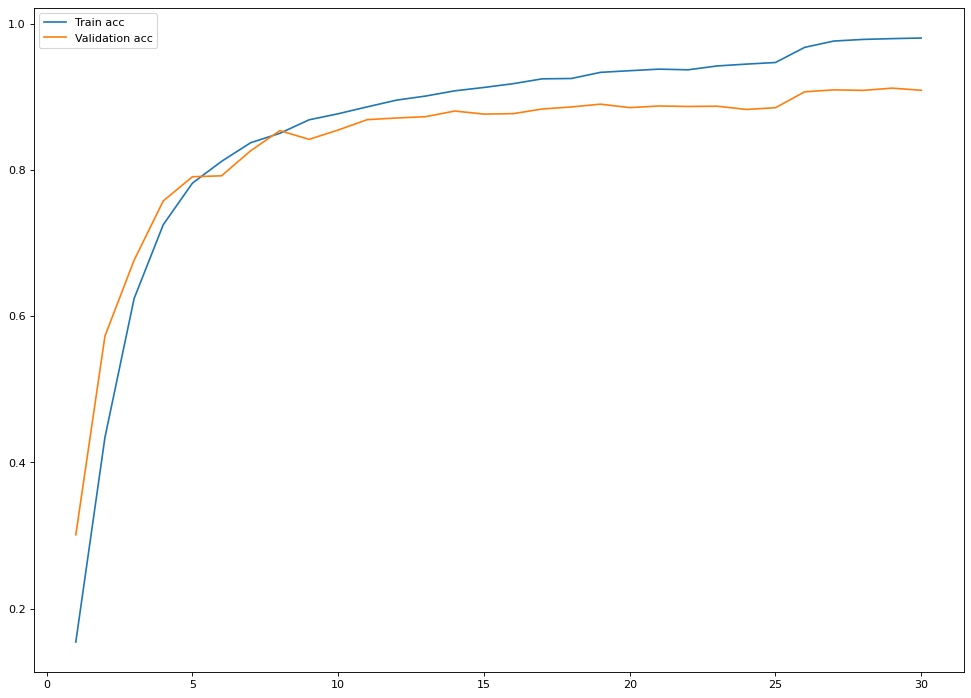

In [92]:
figure(figsize=(15,11), dpi=80)
plt.plot(range(1,31), tr_loss,label = "Train acc")
plt.plot(range(1,31), val_los, label = "Validation acc")
plt.legend()

In [93]:
model4 = RNN2(16000, 512, 4, len(labels)).cuda()

In [114]:
def prediction(model,test_dataloader):
    with torch.no_grad():
        model.eval()
        prediction = np.empty([0], dtype=np.int8)


        for test_batch in tqdm(test_dataloader, desc="Testing"):
            x, _ = test_batch
            x = x.cuda()
            logits = model(x)
            logits_argmax = logits.argmax(dim = -1).squeeze()
            prediction = np.append(prediction,logits_argmax.cpu().numpy())
    return prediction

In [109]:
from sklearn.metrics import confusion_matrix

pred_val = prediction(model4, val_loader)

true_labels = [label_to_index(x[2]) for x in val_set]

cm = confusion_matrix(pred_val, true_labels)


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.69it/s]


In [ ]:
import seaborn as sns

figure(figsize=(20,20), dpi=80)

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('LSTM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([index_to_label(x) for x in range(31)])
ax.yaxis.set_ticklabels([index_to_label(x) for x in range(31)])

## Display the visualization of the Confusion Matrix.
plt.show()

After executing the entire code, we later realised that we did the confusion matrix wrong, so we added the correct image.

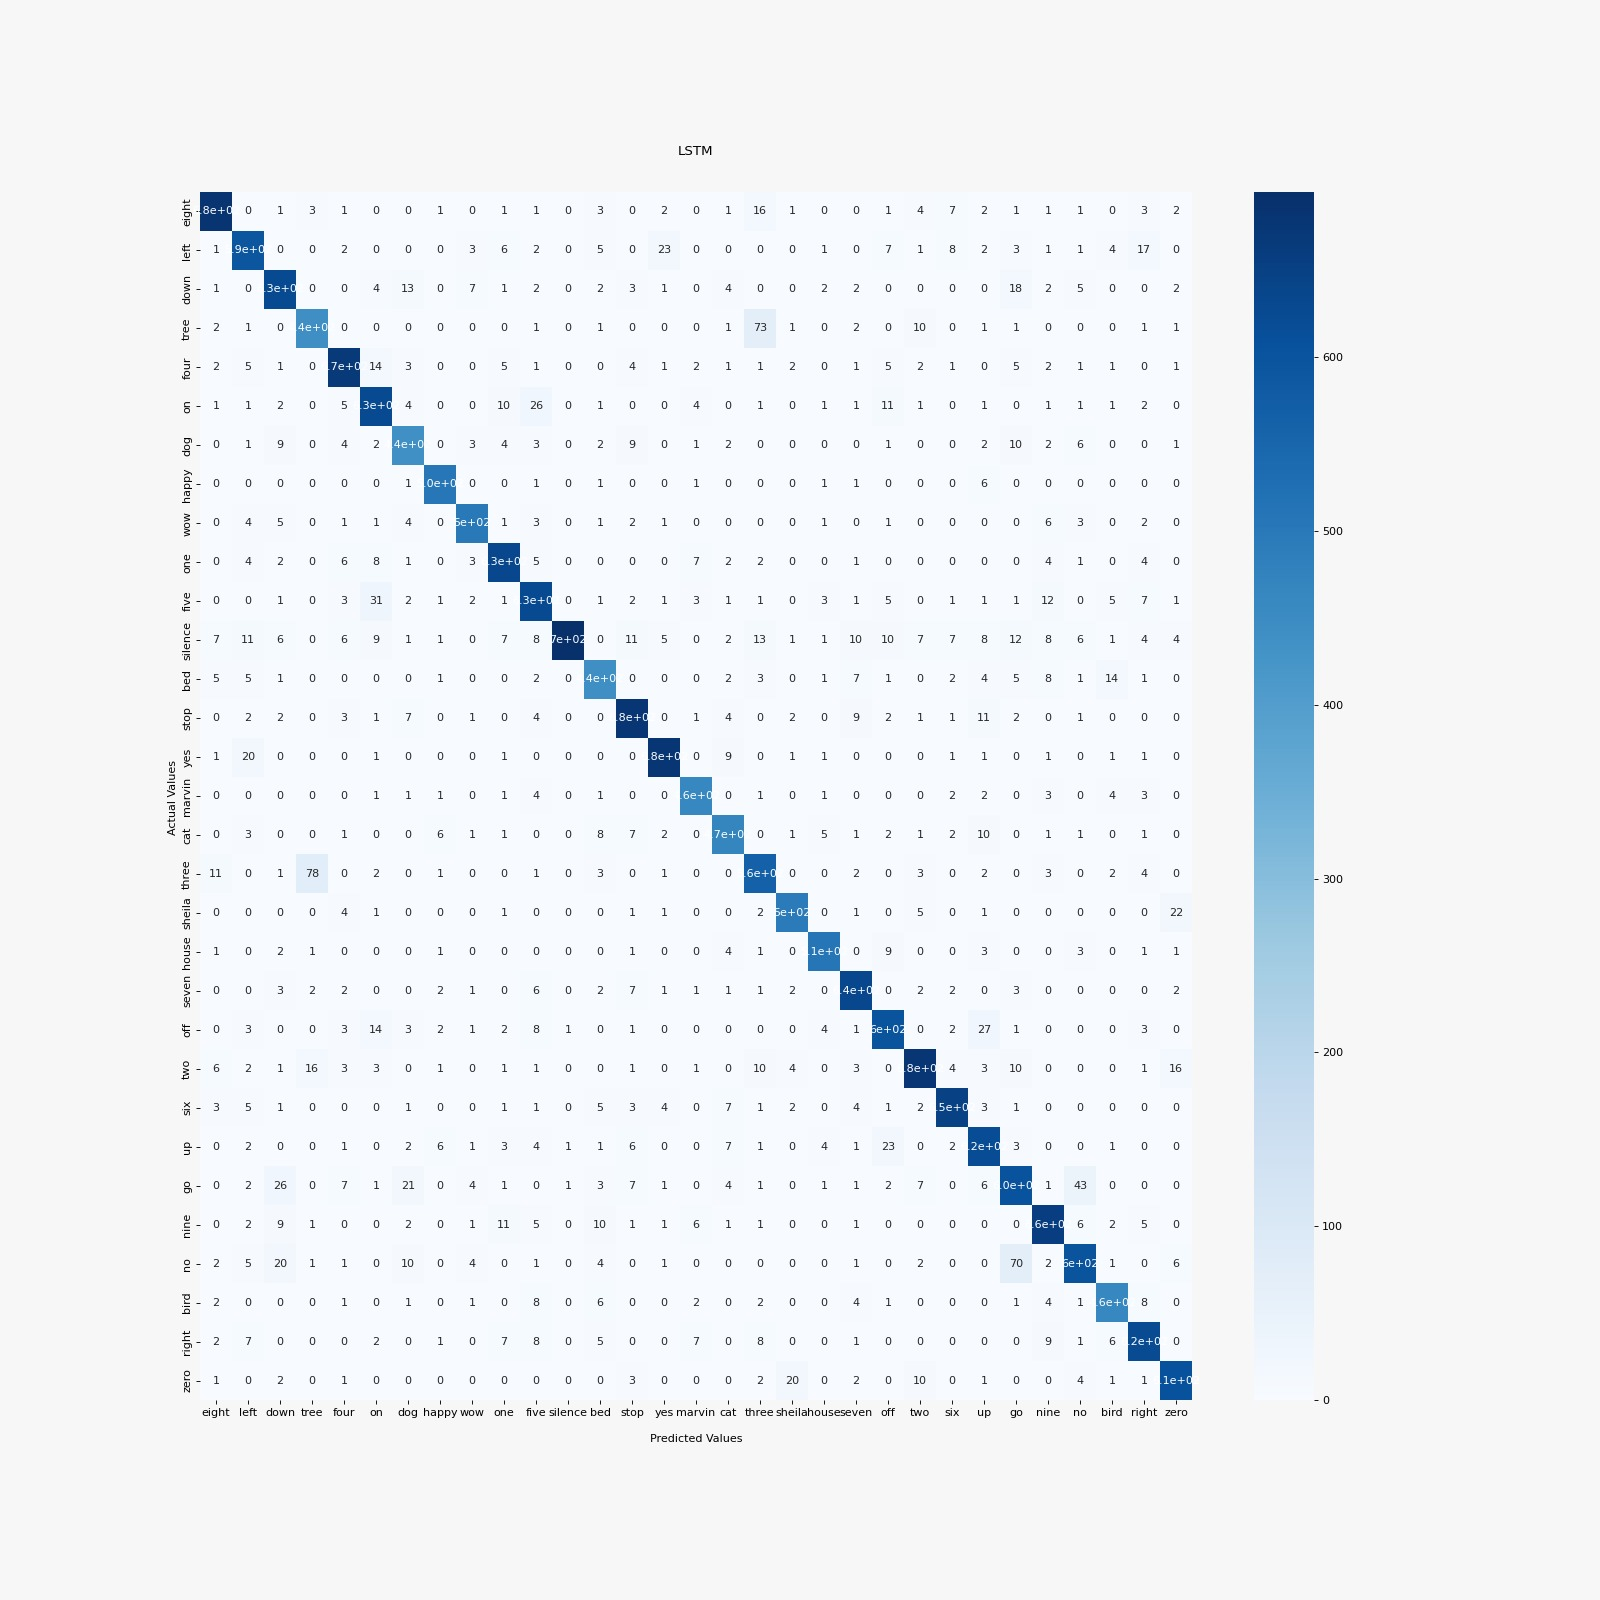

In [94]:
testset = SpeechDataset("./test",None, exclude = lambda x: x.startswith('_background_noise_'))


test_set = testset.getTrainValidationSubset()


In [95]:
whole_loader = DataLoader(
    whole_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

In [96]:
labels.append("audio")

In [98]:
tr_loss, val_los = train(model4, whole_loader, num_epochs=30, lr = 0.001, keepBest = False, metrics= metrics1)

Training (epoch=0/30): 100%|██████████| 263/263 [00:56<00:00,  4.68it/s, batch acc=0.328]


Train acc 0.17623225537366125


Training (epoch=1/30): 100%|██████████| 263/263 [00:56<00:00,  4.68it/s, batch acc=0.557]


Train acc 0.5288755157672084


Training (epoch=2/30): 100%|██████████| 263/263 [00:56<00:00,  4.68it/s, batch acc=0.672]


Train acc 0.6799189668270448


Training (epoch=3/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=0.754]


Train acc 0.7512549714745356


Training (epoch=4/30): 100%|██████████| 263/263 [00:56<00:00,  4.68it/s, batch acc=0.787]


Train acc 0.7963594655385577


Training (epoch=5/30): 100%|██████████| 263/263 [00:56<00:00,  4.68it/s, batch acc=0.803]


Train acc 0.828191798370399


Training (epoch=6/30): 100%|██████████| 263/263 [00:56<00:00,  4.69it/s, batch acc=0.803]


Train acc 0.8492246734095006


Training (epoch=7/30): 100%|██████████| 263/263 [00:56<00:00,  4.68it/s, batch acc=0.836]


Train acc 0.8625117304455335


Training (epoch=8/30): 100%|██████████| 263/263 [00:55<00:00,  4.70it/s, batch acc=0.885]


Train acc 0.8788822188789418


Training (epoch=9/30): 100%|██████████| 263/263 [00:55<00:00,  4.70it/s, batch acc=0.918]


Train acc 0.8880431382479556


Training (epoch=10/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=0.902]


Train acc 0.897650931732531


Training (epoch=11/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=0.902]


Train acc 0.9080482028212653


Training (epoch=12/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=0.902]


Train acc 0.9101783027721091


Training (epoch=13/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=0.902]


Train acc 0.917775162736657


Training (epoch=14/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=0.852]


Train acc 0.9219459878152324


Training (epoch=15/30): 100%|██████████| 263/263 [00:55<00:00,  4.72it/s, batch acc=0.885]


Train acc 0.9256997303859503


Training (epoch=16/30): 100%|██████████| 263/263 [00:55<00:00,  4.72it/s, batch acc=0.918]


Train acc 0.93106221977269


Training (epoch=17/30): 100%|██████████| 263/263 [00:55<00:00,  4.70it/s, batch acc=0.918]


Train acc 0.9348904413626682


Training (epoch=18/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=0.885]


Train acc 0.9395826195760654


Training (epoch=19/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=0.967]


Train acc 0.9396273069876215


Training (epoch=20/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=0.852]


Train acc 0.9413254286267558


Training (epoch=21/30): 100%|██████████| 263/263 [00:55<00:00,  4.70it/s, batch acc=0.951]


Train acc 0.9466730222096436


Training (epoch=22/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=0.951]


Train acc 0.9481774983987011


Training (epoch=23/30): 100%|██████████| 263/263 [00:55<00:00,  4.72it/s, batch acc=0.934]


Train acc 0.9534953003738846


Training (epoch=24/30): 100%|██████████| 263/263 [00:55<00:00,  4.72it/s, batch acc=0.885]


Train acc 0.9521844696349039


Training (epoch=25/30): 100%|██████████| 263/263 [00:55<00:00,  4.70it/s, batch acc=0.967]


Train acc 0.9687634993222409


Training (epoch=26/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=1]    


Train acc 0.9759730683866354


Training (epoch=27/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=0.951]


Train acc 0.9793246242533479


Training (epoch=28/30): 100%|██████████| 263/263 [00:55<00:00,  4.71it/s, batch acc=1]    


Train acc 0.980456705346104


Training (epoch=29/30): 100%|██████████| 263/263 [00:55<00:00,  4.70it/s, batch acc=0.951]

Train acc 0.9816036822427122


In [99]:
def getSoftMax(model, dataloader):
    with torch.no_grad():
        model.eval()
        outputs = []
        for x,y in dataloader:
            x = x.cuda()
            outputs.append(F.softmax(model(x),dim=1).cpu())
    return torch.cat(outputs, dim=0)
        

In [101]:
whole_loader_noshuffle = DataLoader(
    whole_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

train_loader_noshuffle = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

val_loader_noshuffle = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

In [102]:
softmaxs_train = getSoftMax(model4, train_loader_noshuffle)
softmaxs_val = getSoftMax(model4, val_loader_noshuffle)
softmaxs_whole = getSoftMax(model4, whole_loader_noshuffle)

In [103]:
softmaxs_val_copy = copy.deepcopy(list(softmaxs_val.numpy()))
a = sorted(list(range(len(softmaxs_val_copy))),key = lambda x : (
    softmaxs_val_copy[x].sort(),
   softmaxs_val_copy[x][-2]
))
a[-10:]

[11244, 5009, 10974, 6566, 2290, 14091, 20076, 9895, 17459, 9528]

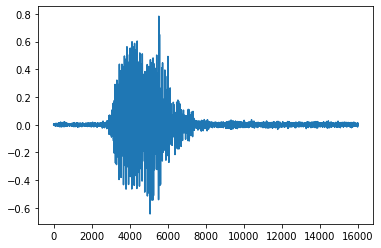

17459
go
tensor([1.5107e-04, 5.7206e-05, 1.2671e-04, 7.8269e-05, 8.8240e-04, 5.2174e-05,
        7.7534e-03, 1.7313e-06, 5.0331e-01, 2.5330e-04, 4.6339e-06, 1.2932e-04,
        1.2798e-05, 4.3262e-04, 4.6283e-05, 3.0217e-07, 7.2158e-04, 8.7957e-07,
        1.3672e-05, 1.2712e-03, 1.0927e-07, 5.3112e-03, 8.8066e-04, 1.0929e-05,
        2.0636e-05, 4.6740e-01, 1.8724e-06, 1.0587e-02, 7.1309e-06, 2.9555e-04,
        3.0039e-05, 1.5234e-04])


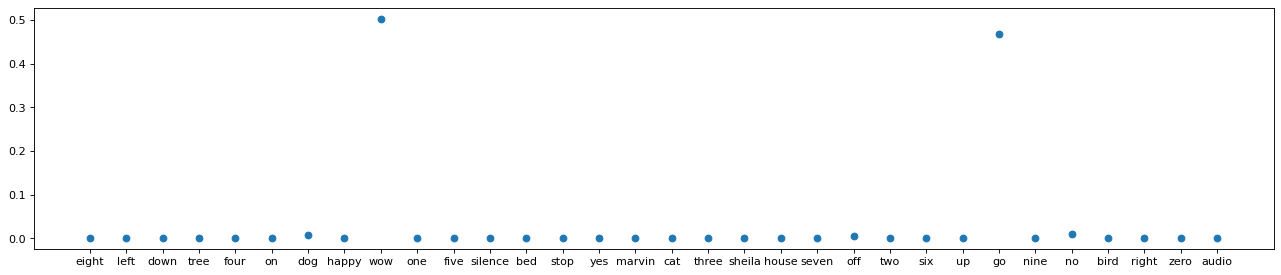

Predition wow


In [106]:
#index = random.randint(0, len(val_set))
index = 17459
waveform, sample_rate, label,= val_set[index]

plt.plot(waveform.t().numpy());
plt.show()
waveform.shape


import IPython

print(index)
print(label)
print(softmaxs_val[index])
figure(figsize=(20, 4), dpi=80)
plt.scatter([index_to_label(i) for i in range(0,len(softmaxs_val[index]))],softmaxs_val[index])
plt.show()
logits_argmax = softmaxs_val[index].argmax(dim = -1).squeeze()
print("Predition", index_to_label(int(logits_argmax)))
torchaudio.save('a.wav', waveform, 16000)
IPython.display.Audio("a.wav")

In [111]:
softmaxs_test_copy = copy.deepcopy(list(softmaxs_test.numpy()))
a = sorted(list(range(len(softmaxs_test_copy))),key = lambda x : (
   softmaxs_test_copy[x].sort(),
   softmaxs_test_copy[x][-2]
))
a[-20:]

[108393,
 61027,
 126343,
 122754,
 44881,
 155898,
 55624,
 104292,
 115690,
 2133,
 123893,
 10994,
 11242,
 7089,
 147917,
 12125,
 47924,
 62987,
 106843,
 8270]

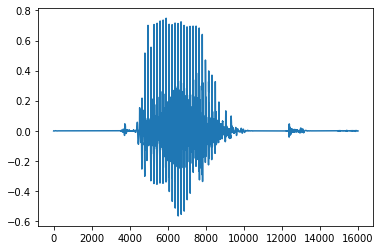

8270
audio
31


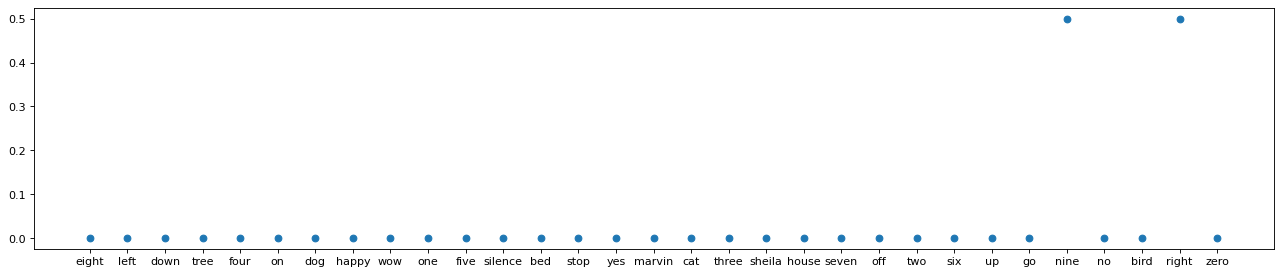

Predition nine


In [112]:
#index = random.randint(0, len(test_set))
index = 8270
waveform, sample_rate, label,= test_set[index]

plt.plot(waveform.t().numpy());
plt.show()
waveform.shape


import IPython

print(index)
print(label)
print(len(softmaxs_test[index]))
figure(figsize=(20, 4), dpi=80)
plt.scatter([index_to_label(i) for i in range(0,len(softmaxs_test[index]))],softmaxs_test[index])
plt.show()
logits_argmax = softmaxs_test[index].argmax(dim = -1).squeeze()
print("Predition", index_to_label(int(logits_argmax)))
torchaudio.save('a.wav', waveform, 16000)
IPython.display.Audio("a.wav")

In [115]:
pred = prediction(model4,test_loader)

Testing: 100%|██████████| 620/620 [02:24<00:00,  4.30it/s]


In [116]:
filenames = [a.split("/")[1] for a in testset.getFilenames()]

In [117]:
pred_name = [index_to_label(a) for a in pred]

In [121]:
unique, counts = np.unique(pred_name, return_counts=True)

result = np.column_stack((unique, counts))
print (result)

[['down' '5437']
 ['go' '5608']
 ['left' '5782']
 ['no' '6726']
 ['off' '6302']
 ['on' '6803']
 ['right' '4952']
 ['silence' '15201']
 ['stop' '5838']
 ['unknown' '83614']
 ['up' '6461']
 ['yes' '5814']]


In [120]:
pred_name = [a if a not in no_classes else "unknown" for a in pred_name]

In [122]:
import pandas as pd
df = pd.DataFrame(
    {'fname': filenames,
     'label': pred_name,
    })

In [128]:
#test
label = "a"
while label != "up":
    i = random.randint(0, len(df))
    label  =  df.iloc[i]["label"]
filename = df.iloc[i]["fname"]

import IPython

print(label)
print(i)
IPython.display.Audio("test/audio/"+filename)


up
51369


In [129]:
model_scripted = torch.jit.script(model4) # Export to TorchScript
model_scripted.save('model4_scripted.pt') #

model4 = torch.jit.load('../input/weights/model4_scripted.pt')
model4.eval()

RecursiveScriptModule(
  original_name=RNN2
  (conv1): RecursiveScriptModule(original_name=Conv1d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm1d)
  (pool1): RecursiveScriptModule(original_name=MaxPool1d)
  (conv2): RecursiveScriptModule(original_name=Conv1d)
  (bn2): RecursiveScriptModule(original_name=BatchNorm1d)
  (pool2): RecursiveScriptModule(original_name=MaxPool1d)
  (lstm): RecursiveScriptModule(original_name=LSTM)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc): RecursiveScriptModule(original_name=Linear)
)

In [130]:
df.to_csv('submission.csv', index=False)

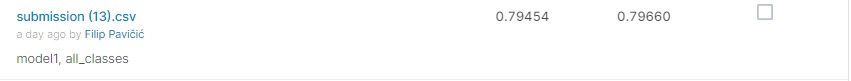